In [1]:
import pandas as pd
from collections import OrderedDict
from nltk import ngrams

In [69]:
# reuse the discretized features that we computed earlier
df = pd.read_csv("data/TotBytes_Dur_discretized.csv")

In [70]:
df["TotBytes_Dur"].value_counts()

8.0     97477
3.0     11559
10.0     4155
15.0     3126
17.0     1720
18.0     1222
16.0     1167
13.0     1050
12.0      445
19.0      113
11.0      107
1.0        17
6.0        16
9.0        12
4.0         5
2.0         3
7.0         2
14.0        2
0.0         1
Name: TotBytes_Dur, dtype: int64

In [71]:
totbytes_dur = df["TotBytes_Dur"].to_numpy()

In [72]:
len(list(ngrams(totbytes_dur, 3)))

122197

In [95]:
import matplotlib.pyplot as plt

In [121]:
import math

In [129]:
import numpy as np

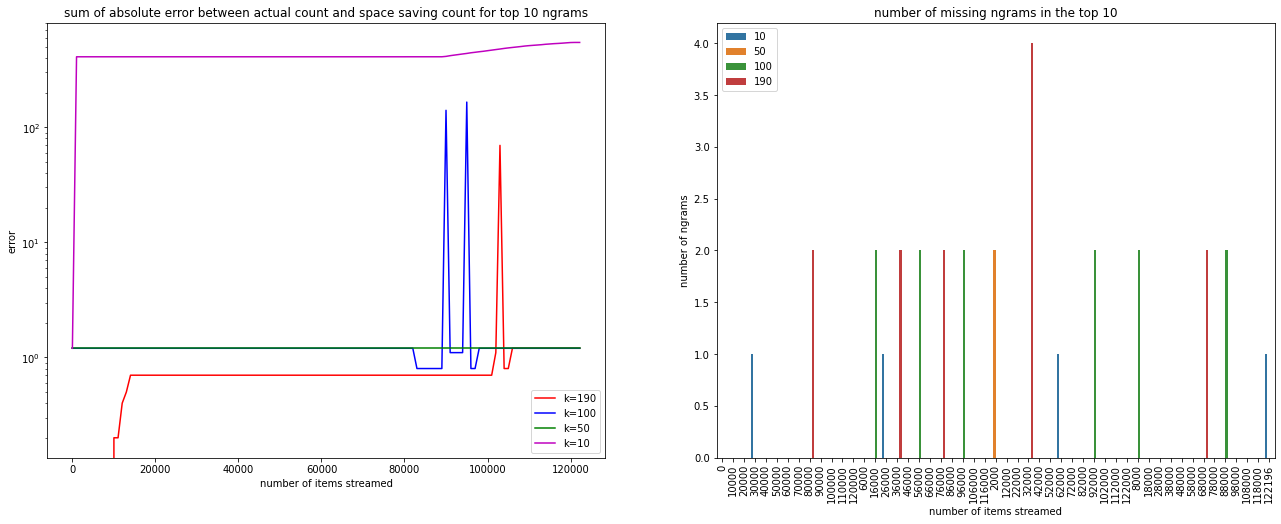

In [251]:
T = OrderedDict()
T_norm = {}
ks = [190, 100, 50, 10]
count_err = {190: [], 100: [], 50: [], 10: []}
item_err_y = []
item_err_k = []
item_err_x = []
bound = {190: [], 100: [], 50: [], 10: []}
colors = {190: 'r', 100: 'b', 50: 'g', 10: 'm'}

f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

# stream ngrams
for k in ks:
    for i, token in enumerate(ngrams(totbytes_dur, 3)):
        # normal counting
        T_norm[token] = T_norm.get(token, 0) + 1

        # space saving
        stored_tokens = T.keys()
        num_stored_tokens = len(stored_tokens)
        if token in stored_tokens:
            T[token] += 1
        elif num_stored_tokens < k:
            T[token] = 1
        else:
            min_count_token = sorted(T.items(), key=lambda kv: kv[1])[0][0]
            T[min_count_token] += 1
            T.pop(min_count_token)

        if i % 1000 == 0 or i == 122196:
            df_ss = pd.DataFrame.from_dict(dict(sorted(T.items(), key=lambda kv: kv[1], reverse=True)[:10]), orient="index", columns=["counts"])
            df_ss.loc[:, "type"] = "space_saving"
            df_ss.reset_index(inplace=True)
            df_ss.rename(columns={"index": "ngram"}, inplace=True)

            df_norm = pd.DataFrame.from_dict(dict(sorted(T_norm.items(), key=lambda kv: kv[1], reverse=True)[:10]), orient="index", columns=["counts"])
            df_norm.loc[:, "type"] = "normal"
            df_norm.reset_index(inplace=True)
            df_norm.rename(columns={"index": "ngram"}, inplace=True)

            merged_df = pd.merge(df_norm[["ngram", "counts"]], df_ss[["ngram", "counts"]], on="ngram", how="left")
            item_err_x.append(i)
            item_err_y.append(sum(1 for i, j in zip(df_ss["ngram"].tolist(), df_norm["ngram"].tolist()) if i != j))
            item_err_k.append(k)
            merged_df["counts_y"].fillna(0, inplace=True)
            a = merged_df["counts_x"].to_numpy() - merged_df["counts_y"]

            merged_df.loc[:, "error"] = a
            count_err[k].append((i, merged_df["error"].mean()))
            bound[k].append(i/k)

    ax1.plot([x[0] for x in count_err[k]], [x[1] for x in count_err[k]], f"{colors[k]}-", label=f"k={k}")

ax1.set_title("sum of absolute error between actual count and space saving count for top 10 ngrams")
ax1.set_xlabel("number of items streamed")
ax1.set_ylabel("error")
ax1.legend()
ax1.set_yscale("log")

sns.barplot(x=item_err_x[::10]+[item_err_x[-1]], y=item_err_y[::10]+[item_err_y[-1]], hue=item_err_k[::10]+[item_err_k[-1]])
ax2.set_xticklabels(item_err_x[::10]+[item_err_x[-1]], rotation=90)
ax2.set_title("number of missing ngrams in the top 10")
ax2.set_xlabel("number of items streamed")
ax2.set_ylabel("number of ngrams")
ax2.legend()

plt.show()

We see that as we stream, the ngrams that are in top 10 according to the space saving algorithm get more accurate. In the figure to the right, we see that for almost all chosen values of k(except 10), there are no missing ngrams that should be there in the top 10. Even for k=10, there is only 1 missing ngram which is quite remarkable.
In the figure to the left, we see that low value of k i.e. 10 has higher mean absolute error of the counts which increase over time while higher values like 50, 100 and 190 show negligible values. The scale of the y axis for the error is in log scale to make the different lines comparable

Based on this, we choose k=50 as sufficient so that we accurate counts while minimizing the space complexity

In [253]:
k=50
for i, token in enumerate(ngrams(totbytes_dur, 3)):
    # normal counting
    T_norm[token] = T_norm.get(token, 0) + 1

    # space saving
    stored_tokens = T.keys()
    num_stored_tokens = len(stored_tokens)
    if token in stored_tokens:
        T[token] += 1
    elif num_stored_tokens < k:
        T[token] = 1
    else:
        min_count_token = sorted(T.items(), key=lambda kv: kv[1])[0][0]
        T[min_count_token] += 1
        T.pop(min_count_token)

In [257]:
ss_count = sorted(T.items(), key=lambda kv: kv[1], reverse=True)[:10]
true_count = sorted(T_norm.items(), key=lambda kv: kv[1], reverse=True)[:10]

In [269]:
err = 0
counts = []
types = []
ngrams = []
for k, (i, j) in enumerate(zip(ss_count, true_count)):
    counts.extend([i[1], j[1]])
    types.extend(["space_saving", "true"])
    ngrams.extend([str(i[0]), str(j[0])])
    if i[0] == j[0]:
        err += j[1] - i[1]
    else:
        print(f"{k+1}th item: {i[0]} missing")
print(f"Total Absolute error between true count and space saving count: {err}")

10th item: (3.0, 3.0, 8.0) missing
Total Absolute error between true count and space saving count: 8


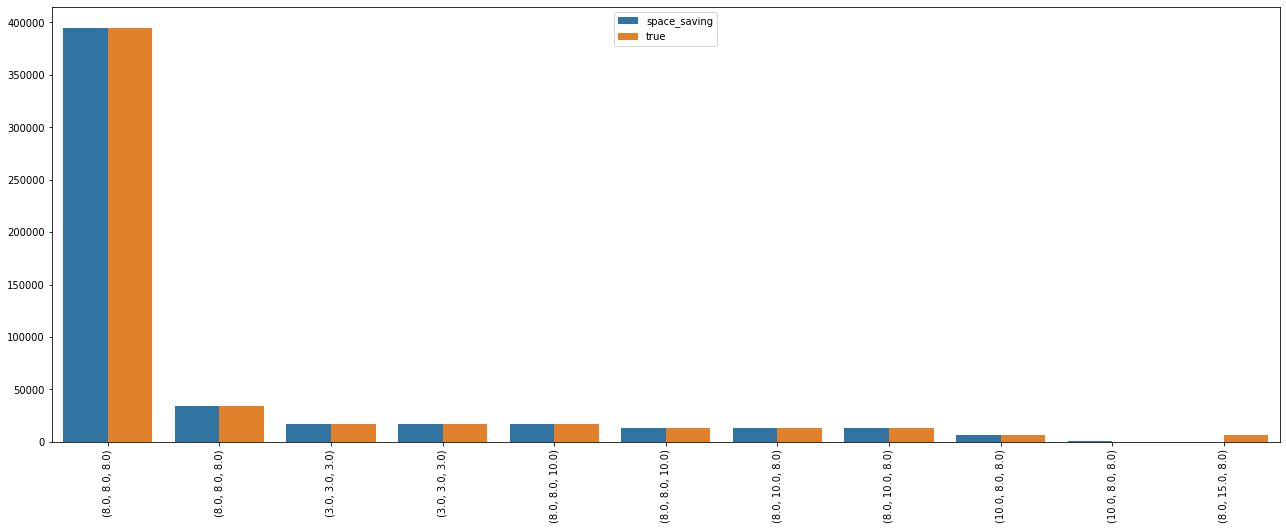

In [273]:
f, ax = plt.subplots(1, 1, figsize =(22, 8))
sns.barplot(x=ngrams, y=counts, hue=types, ax=ax)
ax.set_xticklabels(ngrams, rotation=90)
plt.show()

We can see the for a majority of the top 10, the ngrams are counted exactly, except for the 10th one which is wrongly captured